In [1]:
!pip install torchmetrics
!pip install captum
!rm -rf ./3D-CNN-PyTorch/
!git clone -b improve/add-test-notebook https://github.com/MohsenDehghankar/3D-CNN-PyTorch.git
!ls

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into '3D-CNN-PyTorch'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 81 (delta 24), reused 77 (delta 20), pack-reused 0
Unpacking objects: 100% (81/81), done.
3D-CNN-PyTorch	drive  sample_data


In [2]:
import os
import sys

sys.path.insert(0, os.path.abspath('./3D-CNN-PyTorch')) # this allows local imports

In [3]:
# Local imports
from models import ResNetV2
from models import resnet
from models import DenseNet
from models import ResNeXt
from models import ResNeXtV2
from models import PreActResNet
from models import WideResNet
from models import SqueezeNet
from models import ShuffleNet
from models import ShuffleNetV2
from models import MobileNet
from models import MobileNetV2
from models.EfficientNet import EfficientNet3D

In [4]:
# Package imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import re
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision import transforms
from torch.optim.lr_scheduler import *
from torchvision.io import read_image
from torch.utils.data import Dataset
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from distutils.dir_util import copy_tree
from datetime import datetime
from torchsummary import summary
from torchmetrics import ConfusionMatrix
from sklearn.metrics import *
import json
from itertools import cycle
import numpy as np
import seaborn as sn
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
import torchvision
from torchvision import models

# Interprete
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

print(torch.__version__) 

1.12.1+cu113


In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Config

In [6]:
# Config

# Metadata Configs
DATA_DIR = "/content/drive/MyDrive/lemon-crop"
VAL_DATA_DIR = "/content/drive/MyDrive/lemon-crop/validation"
TRAIN_DATA_DIR = "/content/drive/MyDrive/lemon-crop/train"
TEST_DATA_DIR = "/content/drive/MyDrive/lemon-crop/test"
IMAGE_FILE_NAME_REGEX = "(\d+)\w(\d+).\w+(result\.jpg)"
PREPROCESS_INPUT_IMAGE_SIZE = (160, 120)
TRAIN_TEST_COEF = 0.7

# Main Configs
LR = 0.1
GAMMA = 0.95
BATCH_SIZE = 4
TEST_BATCH_SIZE = 4
ITERS_TO_ACCUMULATE = 2 # if USE_AMP=True
EPOCHS = 100
TRAIN_INPUT_IMAGE_SIZE = (120, 120)
NEEDS_RESIZE = False
CLASS_NUM = 3

# Augmentation
TEST_SET_AUGMENTATION_COEF = 2

# Save model
SAVE_CHECKPOINTS = True
CHECKPOINTS_DIR = "/content/drive/MyDrive/lemon-crop/model_checkpoints"
MIN_ACC_TO_SAVE = 90

# Other
USE_CUDA = True
DRY_RUN = False
LOG_INTERVAL = 8 # should be multiply of ITERS_TO_ACCUMULATE
USE_AMP = True ## Memory Boost ##
ADD_CHANNEL_TO_INPUT = True # if true, adds a channel dimenstion to data in test() and train() [False for LSTM]

# Data Preparation


## Load Metadata


In [7]:
labels_map = {
    0: "Salem",
    1: "Bruised-8",
    2: "Bruised-24",
}
metadata_dir = "./drive/MyDrive/lemon-crop/metadata"
dir_map = {
    0: "salem",
    1: os.path.join("Bruised", "8"),
    2: os.path.join("Bruised", "24"),
}
dir_map_secondary = {
    0: "salem",
    1: "8",
    2: "24",
}

In [8]:
# load metadata

train_metadata = pd.read_csv(os.path.join(metadata_dir, "train_metadata-2.csv"), header=[0]).iloc[: , 1:]
test_metadata = pd.read_csv(os.path.join(metadata_dir, "test_metadata-2.csv"), header=[0]).iloc[: , 1:]
val_metadata = pd.read_csv(os.path.join(metadata_dir, "val_metadata.csv"), header=[0]).iloc[: , 1:]
labels_metadata = pd.read_csv(os.path.join(metadata_dir, "labels_metadata-2.csv"), header=[0]).iloc[: , 1:]
print(len(train_metadata), len(test_metadata), len(val_metadata), len(labels_metadata))

145 42 28 208


## Define Dataset


In [9]:
# Create Dataset Class


class LemonDataset(Dataset):
    def __init__(
        self,
        annotations_file,
        pure_img_dir,
        processed_img_dir,
        preprocess_transform=None,
        target_transform=None,
        preprocess=False,
        transform=None
    ):
        self.img_labels = annotations_file
        self.pure_img_dir = pure_img_dir
        self.processed_img_dir = processed_img_dir
        self.preprocess_transform = preprocess_transform
        self.transform = transform
        self.target_transform = target_transform
        self.preprocess = preprocess

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        row = self.img_labels.iloc[idx]

        # Get image
        if self.preprocess:
            image = self.preprocess_and_save(row)
        else:
            img_path = self.get_path(row, True)
            image = torch.load(img_path)
            if self.transform:
                image = self.transform(image)

        # Label
        label = int(self.img_labels.iloc[idx, 1])
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

    def preprocess_and_save(self, row):
        img_path = self.get_path(row, False)

        # Read and stack image layers
        image_layers = []
        for file in os.listdir(img_path):
            match = re.search(IMAGE_FILE_NAME_REGEX, file)
            if match:
                image_layer = read_image(os.path.join(img_path, file))
                # Transform
                if self.preprocess_transform:
                    image_layer = self.preprocess_transform(image_layer)
                image_layers.append(image_layer[0])

        # Stack
        image = torch.stack(image_layers, dim=0)

        # Save
        torch.save(
            image,
            self.get_path(row, True),
        )

        return image

    def get_path(self, row, preprocessed):
        post_fix = ".pt" if preprocessed else ""
        return os.path.join(
            self.processed_img_dir if preprocessed else self.pure_img_dir,
            dir_map[int(row[-1])],
            row[0] + post_fix,
        )


## Transforms


In [10]:
preprocess_transform = transforms.Compose(
    [
        transforms.Resize(PREPROCESS_INPUT_IMAGE_SIZE),
    ]
)

train_transforms = None
test_transforms = None

### Preprocess and Store data


In [ ]:
# Run this only once to prepare .npy files

'''preprocess_dataset = LemonDataset(
    annotations_file=labels_metadata,
    pure_img_dir=DATA_DIR,
    processed_img_dir=DATA_DIR,
    preprocess=True,
    preprocess_transform=preprocess_transform
)

for i in range(len(preprocess_dataset)):
    print(f"preprocessing {i}...")
    preprocess_dataset[i]
    print(f"preprocessing of {i} finished")'''



'preprocess_dataset = LemonDataset(\n    annotations_file=labels_metadata,\n    pure_img_dir=DATA_DIR,\n    processed_img_dir=DATA_DIR,\n    preprocess=True,\n    preprocess_transform=preprocess_transform\n)\n\nfor i in range(len(preprocess_dataset)):\n    print(f"preprocessing {i}...")\n    preprocess_dataset[i]\n    print(f"preprocessing of {i} finished")'

## Dataloader


In [11]:
# Set kwargs

train_kwargs = {"batch_size": BATCH_SIZE}
test_kwargs = {"batch_size": TEST_BATCH_SIZE}
if USE_CUDA:
    cuda_kwargs = {
        "num_workers": 2,
        "pin_memory": True,
        "shuffle": False,
    }
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)


In [12]:
# Dataloader

train_dataset = LemonDataset(
    annotations_file=train_metadata,
    pure_img_dir=DATA_DIR,
    processed_img_dir=DATA_DIR,
    preprocess_transform=preprocess_transform,
    transform=train_transforms # set this
)

test_dataset = LemonDataset(
    annotations_file=test_metadata,
    pure_img_dir=DATA_DIR,
    processed_img_dir=DATA_DIR,
    preprocess_transform=None,
    transform=test_transforms
)

val_dataset = LemonDataset(
    annotations_file=val_metadata,
    pure_img_dir=DATA_DIR,
    processed_img_dir=DATA_DIR,
    preprocess_transform=None,
    transform=None
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    # drop_last=True,
    **train_kwargs,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    # drop_last=True,
    **test_kwargs,
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=TEST_BATCH_SIZE
)


### Visualize Dataset

In [13]:
test_dataset[0][0].shape

torch.Size([174, 160, 120])

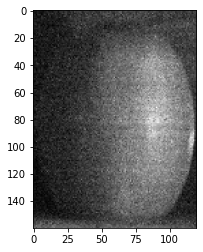

In [14]:
plt.imshow(test_dataset[0][0][0], cmap="gray");

# Models
Only use one of them for each run.

## v1

In [ ]:

# Define Model Class


class ModelV1(nn.Module):
    def __init__(self):
        super(ModelV1, self).__init__()
        # (174, 160, 120)
        self.conv1 = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=(3, 3, 3)),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),
            nn.BatchNorm3d(64),
        )

        self.conv2 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=(3, 3, 3)),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),
            nn.BatchNorm3d(128),
        )

        self.conv3 = nn.Sequential(
            nn.Conv3d(128, 128, kernel_size=(3, 3, 3)),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),
            nn.BatchNorm3d(128),
        )

        self.conv4 = nn.Sequential(
            nn.Conv3d(128, 128, kernel_size=(3, 3, 3)),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),
            nn.BatchNorm3d(128),
        )

        self.linear = nn.Sequential(
            nn.Linear(46080, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 4)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

model = ModelV1()
model.name = "ModelV1"

## v2

In [ ]:

# Define Model Class
from torch import nn

class ModelV2(nn.Module):
    def __init__(self):
        super(ModelV2, self).__init__()
        # (174, 160, 120)
        self.conv1 = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=(3, 3, 3)),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),
            nn.BatchNorm3d(8),
        )

        self.conv2 = nn.Sequential(
            nn.Conv3d(8, 8, kernel_size=(3, 3, 3)),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),
            nn.BatchNorm3d(8),
        )

        self.conv3 = nn.Sequential(
            nn.Conv3d(8, 16, kernel_size=(3, 3, 3)),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),
            nn.BatchNorm3d(16),
        )

        self.conv4 = nn.Sequential(
            nn.Conv3d(16, 16, kernel_size=(3, 3, 3)),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),
            nn.BatchNorm3d(16),
        )

        self.linear = nn.Sequential(
            nn.Linear(5760, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 4)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

model = ModelV2()
model.name = "ModelV2"

## v3

In [ ]:
# Define Model Class
from torch import nn

class ModelV3(nn.Module):
    def __init__(self):
        super(ModelV3, self).__init__()
        # (174, 160, 120)
        self.conv1 = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=(3, 3, 3)),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),
            nn.BatchNorm3d(64),
        )

        self.conv2 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=(3, 3, 3)),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),
            nn.BatchNorm3d(128),
        )

        self.conv3 = nn.Sequential(
            nn.Conv3d(128, 256, kernel_size=(3, 3, 3)),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),
            nn.BatchNorm3d(256),
        )

        self.conv4 = nn.Sequential(
            nn.Conv3d(256, 256, kernel_size=(3, 3, 3)),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),
            nn.BatchNorm3d(256),
        )

        self.linear = nn.Sequential(
            nn.Linear(92160, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 4)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

model = ModelV3()
model.name = "ModelV3"

## Resnet

In [ ]:
model = resnet.generate_model(
    model_depth=34, # [10, 18, 34, 50, 101, 152, 200]
    n_input_channels=1,
    n_classes=3
)
model.name = "Resnet"

## ResnetV2

In [15]:
model = ResNetV2.generate_model(
    model_depth=34, # [10, 18, 34, 50, 101, 152, 200]
    n_input_channels=1,
    n_classes=CLASS_NUM
)
model.name = "ResnetV2-3-class" 

## DenseNet

In [ ]:
model = DenseNet.generate_model(
    model_depth=121,
    num_classes=3
)
model.name = "DenseNet"

/content/3D-CNN-PyTorch/models/DenseNet.py:134: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


## ResNeXt

In [ ]:
# Needs resize (174, 120, 120)
model = ResNeXt.generate_model(
    model_depth=50, # [50, 101, 152, 200]
    n_classes=4,
    in_channels=1,
    sample_size=120,
    sample_duration=174,
)
model.name = "ResNetXt"

/content/3D-CNN-PyTorch/models/ResNeXt.py:130: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


## PreActResNet

In [ ]:
model = PreActResNet.generate_model(
    model_depth=50, # [50, 101, 152, 200]
    n_classes=3,
    n_input_channels=1,
)
model.name = "PreActResNet"

## WideResNet

In [ ]:
model = WideResNet.generate_model(
    model_depth=152,
    n_classes=3,
    n_input_channels=1
)
model.name = "WideResNet"

## SqueezeNet

In [ ]:
model = SqueezeNet.get_model(
    version=1.0,
    sample_size=120,
    sample_duration=174,
    num_classes=3,
    in_channels=1,
)
model.name = "SqueezeNet"

## ShuffleNet

In [ ]:
# Needs resize = (160, 160, 120) (ignore now)
model = ShuffleNet.get_model(
    groups=3,
    num_classes=4,
    in_channels=1,
)
model.name = "ShuffleNet"

## ShuffleNetV2

In [ ]:
model = ShuffleNetV2.get_model(
    sample_size=112,
    num_classes=3,
    width_mult=1.0,
    in_channels=1,
)
model.name = "ShuffleNetV2"

## MobileNet

In [ ]:
model = MobileNet.get_model(
    sample_size=120,
    num_classes=3,
    in_channels=1,
)
model.name = "MobileNet"

## MobileNetV2

In [ ]:
model = MobileNetV2.get_model(
    sample_size=112,
    num_classes=3,
    in_channels=1,
)
model.name = "MobileNetV2"

## EfficientNet3D

In [ ]:
model = EfficientNet3D.from_name(
    "efficientnet-b4",
    override_params={"num_classes": 4},
    in_channels=1,
)
model.name = "EfficientNet3D"

'''
 {
        # Coefficients:   width,depth,res,dropout
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5),
        'efficientnet-b8': (2.2, 3.6, 672, 0.5),
        'efficientnet-l2': (4.3, 5.3, 800, 0.5),
}
'''

"\n {\n        # Coefficients:   width,depth,res,dropout\n        'efficientnet-b0': (1.0, 1.0, 224, 0.2),\n        'efficientnet-b1': (1.0, 1.1, 240, 0.2),\n        'efficientnet-b2': (1.1, 1.2, 260, 0.3),\n        'efficientnet-b3': (1.2, 1.4, 300, 0.3),\n        'efficientnet-b4': (1.4, 1.8, 380, 0.4),\n        'efficientnet-b5': (1.6, 2.2, 456, 0.4),\n        'efficientnet-b6': (1.8, 2.6, 528, 0.5),\n        'efficientnet-b7': (2.0, 3.1, 600, 0.5),\n        'efficientnet-b8': (2.2, 3.6, 672, 0.5),\n        'efficientnet-l2': (4.3, 5.3, 800, 0.5),\n}\n"

## Ensemble

In [ ]:
model1 = ResNetV2.generate_model(
    model_depth=34, # [10, 18, 34, 50, 101, 152, 200]
    n_input_channels=1,
    n_classes=3
)
model1.name = "ResnetV2-3-class"
model2 = ResNetV2.generate_model(
    model_depth=34, # [10, 18, 34, 50, 101, 152, 200]
    n_input_channels=1,
    n_classes=3
)
model2.name = "ResnetV2-3-class"
model3 = ResNetV2.generate_model(
    model_depth=34, # [10, 18, 34, 50, 101, 152, 200]
    n_input_channels=1,
    n_classes=3
)
model3.name = "ResnetV2-3-class"

class Ensemble(nn.Module):
    def __init__(self, model1, model2, model3):
        super(Ensemble, self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
        self.fc1 = nn.Linear(3, 3)

    def forward(self, x):
        outs = self.model1(x) + self.model2(x) + self.model3(x)
        out = self.fc1(outs)
        return out

model = Ensemble(model1, model2, model3)
model.name = "Ensemble-ResnetV2-3-class"

def init_weights(m):
    try:
        torch.nn.init.xavier_uniform(m.weight)
    except:
        pass # ignore

model = model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


# Train & Test


## Load Model

In [16]:
# Load model
model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, f"model-cnn-ResnetV2-3-class-93.pt")))

<All keys matched successfully>

In [34]:
gpu = torch.device("cuda")
model = model.to(gpu)
input = test_dataset[40][0].to(gpu)
input = input[None,:][None,:].float()
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = labels_map[pred_label_idx.item()]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: Bruised-24 ( 0.4187103807926178 )


In [36]:
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200, internal_batch_size=4)

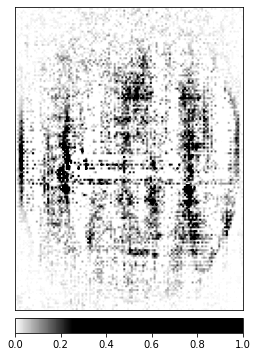

In [37]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

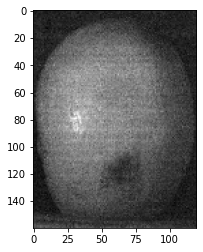

In [38]:
plt.imshow(test_dataset[40][0][170], cmap="gray");

In [36]:
test_dataset[10][1]

1